# ROI Classifier

### This script uses a pre-trained net to label pre-extracted ROIs


Input ROIs: stat.npy file \
Input Net: .pth torch net file, PLUS you must copy and paste the architecture into this script

ROI Classification
--
Info about classes:  
This scripts includes a pretrained model to classify ROIs as one of the following categories:
- **Label 0:** Neuron + In-plane ("Great")
- **Label 1:** Neuron + Semi-in-plane ("Okay")
- **Label 4:** Neuron + Out of plane ("Poor")
- **Label 5:** Dendrite

(*note that during the manual labeling, 0-5 is actually 1-6*)  <br>
(*label 2 is for weird blobs and shadows of neurons*)  <br>
(*label 3 is empty on purpose*)  <br>
___

Info about CURRENT neural network:  
The network is trained on ~4700 ROIs from one FOV  
(mouse 6.28 , recorded on 20200903)  
- **Net_ROIClassifier_20200917.pth** state_dict file must be in path
- This script is specifically for the above .pth parameters file. Changes to the architecture cannot be made here.
___

Input data requirements of classifier net:
---
- 36x36 images
- dim1: image number
- dim 2,3: y,x
- should be normalized between 0-1  


- **There are cell blocks to use the 'stat.npy' output from Suite2p and convert to the required format**


- Full FOV size (in pixels) should be known. Default=512x1024
___



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# import sys
# import copy

import numpy as np

import scipy
import scipy.signal
from scipy.io import savemat

import matplotlib.pyplot as plt

import sys

import pathlib

In [3]:
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

Autodetected operating system: Windows. Using "\\" for directory slashes


In [4]:
## lOAD & PREPROCESS stat.npy file
## outputs: 'images' (input into CNN)

dir_S2p_load = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/suite2p/plane0'
fileName_stat_load = 'stat.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_stat_load}'
stat = np.load(path_load, allow_pickle=True)
print(f'stat file loaded from: {path_load}')

fileName_ops_load = 'ops.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_ops_load}'
ops = np.load(path_load, allow_pickle=True)
print(f'ops file loaded from: {path_load}')

fileName_F_load = 'F.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_F_load}'
F = np.load(path_load, allow_pickle=True)
print(f'F file loaded from: {path_load}')

fileName_Fneu_load = 'Fneu.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_Fneu_load}'
Fneu = np.load(path_load, allow_pickle=True)
print(f'Fneu file loaded from: {path_load}')


stat file loaded from: /media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/suite2p/plane0/stat.npy
ops file loaded from: /media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/suite2p/plane0/ops.npy
F file loaded from: /media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/suite2p/plane0/F.npy
Fneu file loaded from: /media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/suite2p/plane0/Fneu.npy


Number of ROIs: 4878


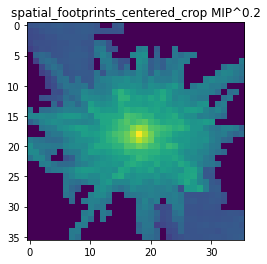

In [5]:
num_ROI = stat.shape[0]
print(f'Number of ROIs: {num_ROI}')

height = 512
width = 1024
spatial_footprints_centered = np.zeros((num_ROI, 241,241))
for i in range(num_ROI):
    spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

%matplotlib inline
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

images = spatial_footprints_centered_crop

In [6]:
F_new = F - 0.7*Fneu
F_baseline = np.percentile(F_new , 30 , axis=1)
dFoF = (F_new - F_baseline[:,None]) / F_baseline[:,None]

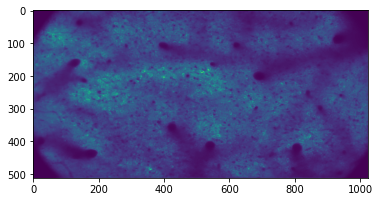

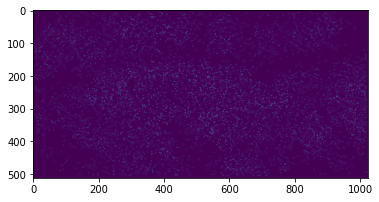

In [8]:
meanImg = ops[()]['meanImg']
frame_height = meanImg.shape[0]
frame_width = meanImg.shape[1]

plt.figure()
plt.imshow(meanImg)

masks_all_flat = np.zeros_like(meanImg)
for ii in range(len(stat[()])):
    masks_all_flat[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam']

plt.figure()
plt.imshow(masks_all_flat)

In [9]:
## Define model architecture
## DO NOT CHANGE ANYTHING HERE!!!
## This architecture is linked to the .pth parameters file

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, PReLU, Softplus, Softmax2d
from torch.optim import Adam, SGD

dropout_prob = 0
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(1, 6, kernel_size=4, stride=1, padding=0),
            BatchNorm2d(6, momentum=momentum_val),
            Dropout(dropout_prob*0.3),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(6, 64, kernel_size=4, stride=1, padding=0),
            Dropout(dropout_prob*1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(64, 128, kernel_size=4, stride=1, padding=0),
            BatchNorm2d(128, momentum=momentum_val),
            Dropout(dropout_prob*1),
            GELU(),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(128, 128),
            GELU(),
            Linear(128, 128),
            GELU(),
            Linear(128, 128),
            GELU(),
            Sigmoid(),
            Linear(128, 6),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.linear_layers(x)
        return x 

dropout_prob = 0.0
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            BatchNorm2d(1, momentum=momentum_val),
            Conv2d(1, 6, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(6, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
           # Defining a 2D convolution layer
            Conv2d(6, 16, kernel_size=4, stride=1, padding=2),
            BatchNorm2d(16, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            Conv2d(16, 64, kernel_size=4, stride=1, padding=2),
            BatchNorm2d(64, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
#             Softmax2d(),
            MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
#             BatchNorm2d(16, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
#             Softmax2d(),
            MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            Conv2d(64, 16, kernel_size=4, stride=1, padding=2),
#             BatchNorm2d(16, momentum=momentum_val),
            SELU(),
#             Dropout(dropout_prob*0.1),
#             Softmax2d(),
            MaxPool2d(kernel_size=2, stride=2),

        )

        self.linear_layers = Sequential(
            
            Linear(64, 16),
            Dropout(dropout_prob * 1),
            SELU(),
#             Softmax(dim=0),
#             Sigmoid(),
            
            
            Linear(16, 64),
            Dropout(dropout_prob * 1),
            SELU(),

            Linear(64, 6),
#             ReLU(),
#             Softmax(dim=0),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
# #         x = x.view(x.size(0), -1)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
        x = self.linear_layers(x)
        return x 

In [10]:
dropout_prob = 0.0
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0),
#             Tanh(),
            ReLU(),
#             BatchNorm2d(6, momentum=momentum_val),
#             AvgPool2d(kernel_size=2),           
            
            Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=0),
            MaxPool2d(kernel_size=2, stride=2),           
#             Tanh(),
            ReLU(),
#             BatchNorm2d(16, momentum=momentum_val),
            Dropout(dropout_prob*1),
            
            Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1),
            MaxPool2d(kernel_size=2, stride=2),           
#             Tanh(),
            ReLU(),
#             BatchNorm2d(16, momentum=momentum_val),
            Dropout(dropout_prob*1),

            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0),
#             BatchNorm2d(16, momentum=momentum_val),
            MaxPool2d(kernel_size=2, stride=2),           
#             Tanh(),
            ReLU(),
            Dropout(dropout_prob*1),   
            
#             Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=1, padding=0),
#             Tanh(),
# #             ReLU(),
# #             MaxPool2d(kernel_size=2, stride=2),           
            
            
            
#             # Defining a 2D convolution layer
#             BatchNorm2d(1, momentum=momentum_val),
#             Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
#             BatchNorm2d(8, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
#             MaxPool2d(kernel_size=2, stride=2),
            
#            # Defining a 2D convolution layer
#             Conv2d(8, 16, kernel_size=4, stride=1, padding=1),
#             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
#             MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(16, 32, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(64, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(256, 1024, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(1024, 32, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 16, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),

        )

        self.linear_layers = Sequential(
            Linear(in_features=64, out_features=256),
#             Tanh(),
            ReLU(),
            Dropout(dropout_prob*1),

#             Linear(in_features=256, out_features=64),
# #             Tanh(),
#             ReLU(),
#             Dropout(dropout_prob*1),
            
            Linear(in_features=256, out_features=6),
            
            
#             Linear(1296, 512),
# #             Dropout(dropout_prob * 1),
#             ReLU(),
#             Softmax(dim=0),
# #             Sigmoid(),
            
            
#             Linear(216, 512),
#             Dropout(dropout_prob * 1),
#             ReLU(),

#             Linear(512, 6),
# #             ReLU(),
# #             Softmax(dim=0),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
# #         x = x.view(x.size(0), -1)
#         x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = torch.flatten(x, 1)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
        x = self.linear_layers(x)
        return x 

In [11]:
#### ENTER FILENAME + PATH OF NETWORK .pth FILE

PATH_load_name_netParams = f'ROI_Classifier_20201004{slash_type}Net_trainedOnAug_20201004_trainingSet_mouse628_20200903and20200815.pth'
# PATH_load_name_netParams = f'ROI_Classifier_20200928{slash_type}Net_trainedOnAug_20200928_trainingSet_mouse628_20200903and20200815.pth'
# PATH_load_dir_netParams = 'G:/My Drive/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/'
PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_netParams = f'{PATH_absolute}{slash_type}'

model = Net()
model.load_state_dict(torch.load(f'{PATH_load_dir_netParams}{PATH_load_name_netParams}'))
model.eval()

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): Dropout(p=0.0, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [12]:
input_x = torch.tensor(images[:,None,:,:]).type('torch.FloatTensor')

output = model(input_x).cpu().detach().numpy()
softmax = np.exp(output)
prob = softmax
predictions = np.argmax(list(prob), axis=1)


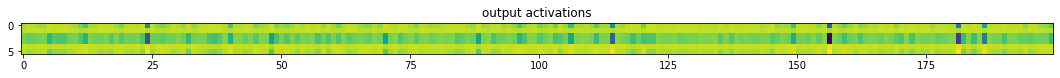

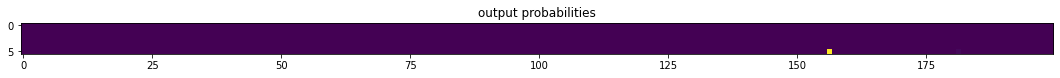

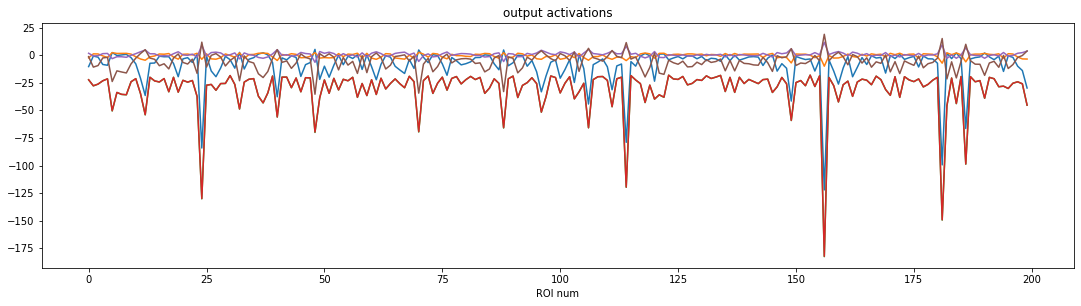

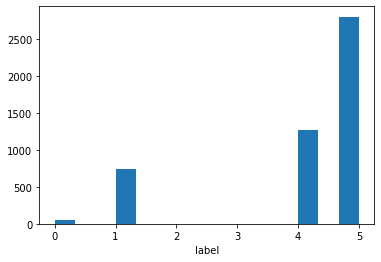

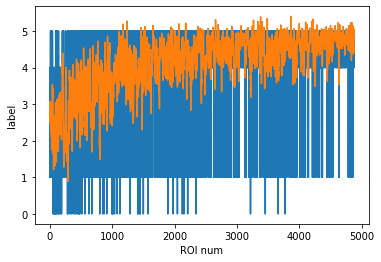

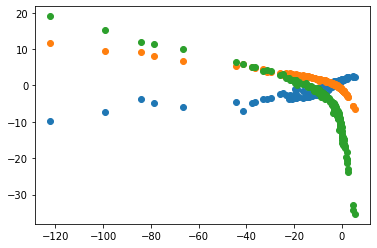

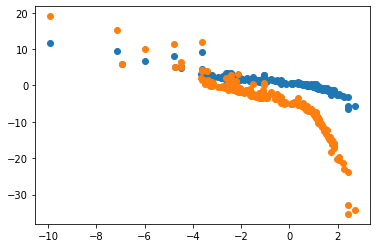

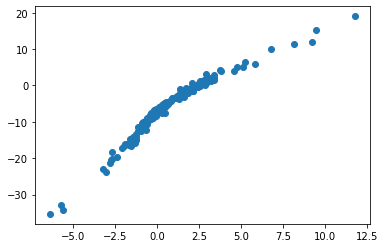

In [13]:
## Show some of the results

ind_to_plot =np.arange(100,300)

%matplotlib inline
fig_output = plt.figure()
plt.imshow(output[ind_to_plot,:].T);
plt.title('output activations');
fig_output.set_size_inches(18.5, 10.5)

fig_prob = plt.figure()
plt.imshow(prob[ind_to_plot,:].T);
plt.title('output probabilities');
fig_prob.set_size_inches(18.5, 10.5)

fig_prob_lines = plt.figure()
plt.plot(output[ind_to_plot,:])
plt.title('output activations');
plt.xlabel('ROI num')
fig_prob_lines.set_size_inches(18.5, 4.5)

fig_predHist = plt.figure()
plt.hist(predictions , 15);
plt.xlabel('label')

fig_predLines = plt.figure()
plt.plot(predictions);
plt.plot(scipy.signal.savgol_filter(predictions,19,3));
plt.xlabel('ROI num')
plt.ylabel('label')

fig_scatterGroups0 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([1])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups1 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups4 = plt.figure()
plt.scatter(output[ind_to_plot , np.array([4])] , output[ind_to_plot , np.array([5])])

<ipython-input-14-a4bdfefa3a93>:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(prob2[:,:6]))


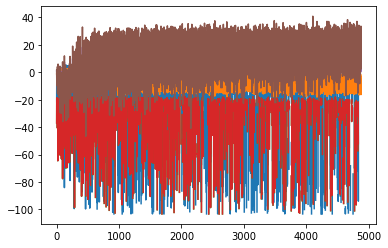

In [14]:
import copy 
prob2 = copy.deepcopy(prob)
prob2[:,4] = prob2[:,4] / 6
predictions2 = np.argmax(list(prob2), axis=1)
plt.figure()
plt.plot(np.log(prob2[:,:6]))

In [15]:
footprints_tall = np.zeros((frame_height*frame_width,4))*np.nan
cc = 0
for ii in range(len(stat)):
    num_pixels = len(stat[()][ii]['ypix'])
    footprints_tall[cc:cc+num_pixels,0] = np.ones(num_pixels)*ii
    footprints_tall[cc:cc+num_pixels,1] = stat[()][ii]['ypix']
    footprints_tall[cc:cc+num_pixels,2] = stat[()][ii]['xpix']
    footprints_tall[cc:cc+num_pixels,3] = stat[()][ii]['lam']
    cc = cc+num_pixels
footprints_tall = footprints_tall[~np.isnan(footprints_tall[:,0]),:]
# footprints_tall
# plt.figure()
# plt.plot(footprints_tall[:,3])

Number of Class 1 ROIs: 57
Number of Class 2 ROIs: 739
Number of Class 5 ROIs: 1276
Number of Class 6 ROIs: 2806


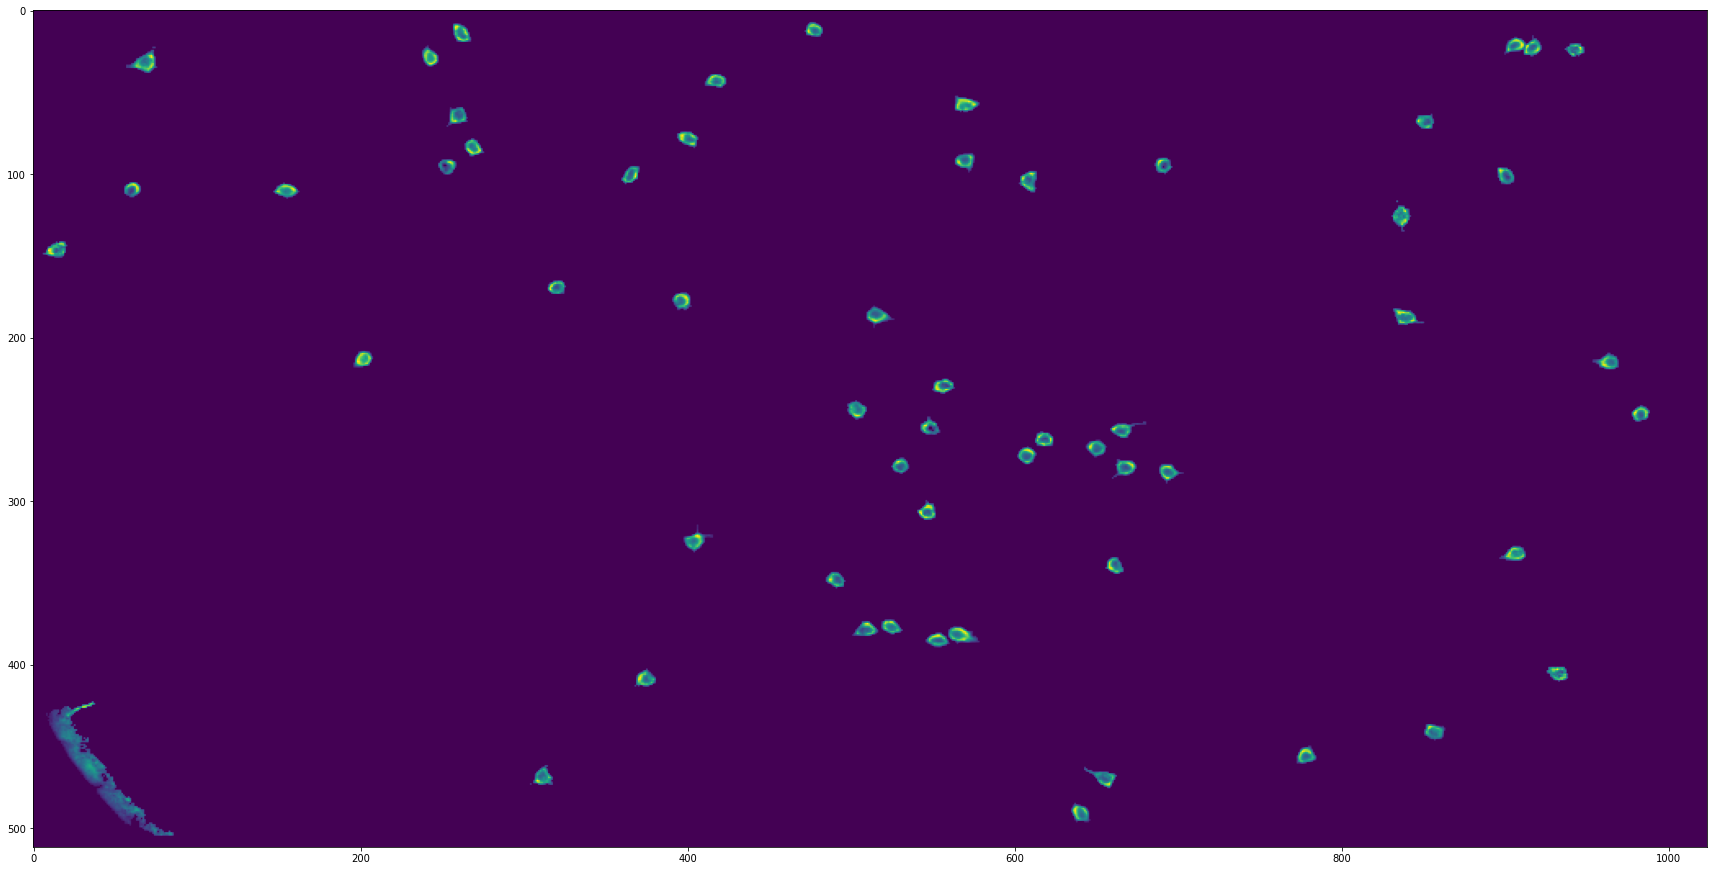

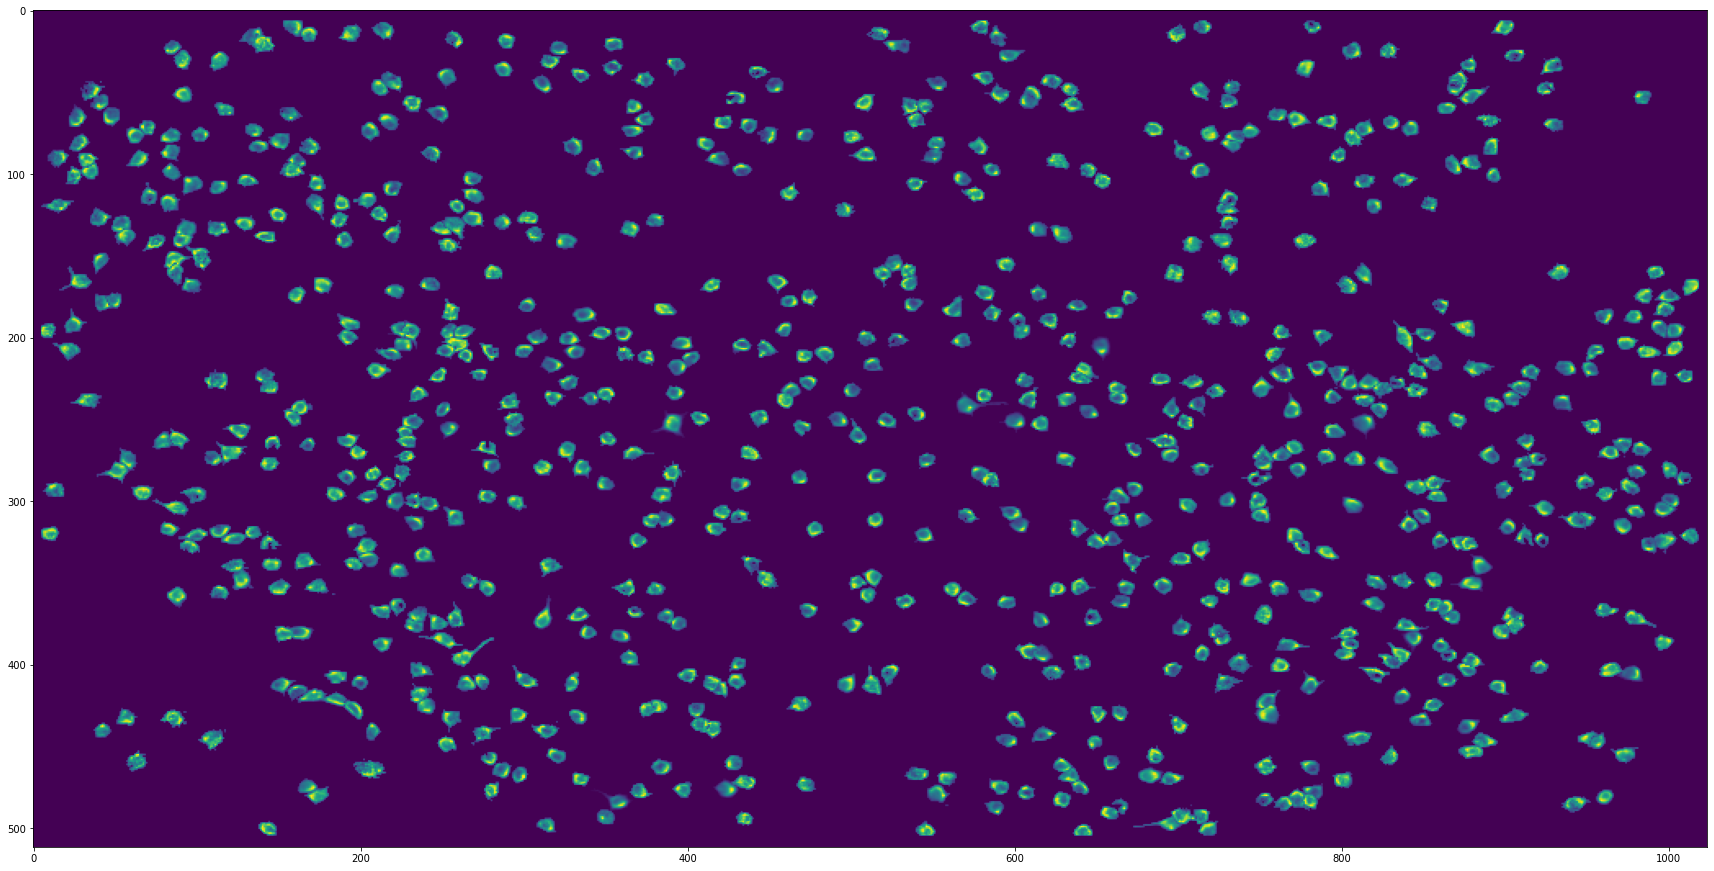

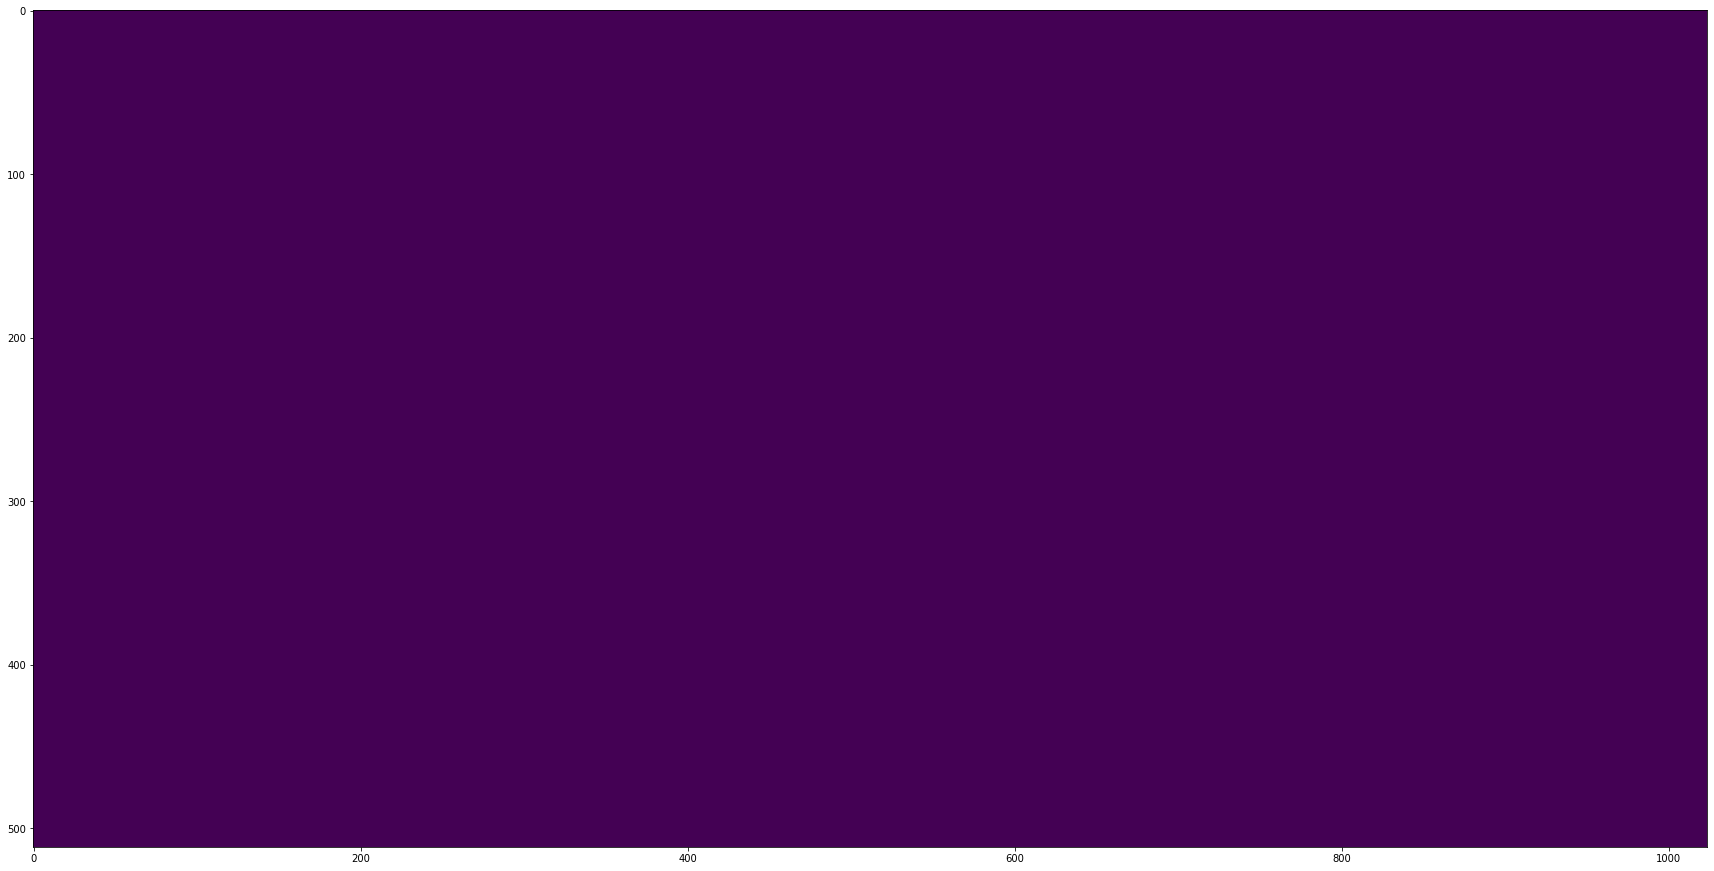

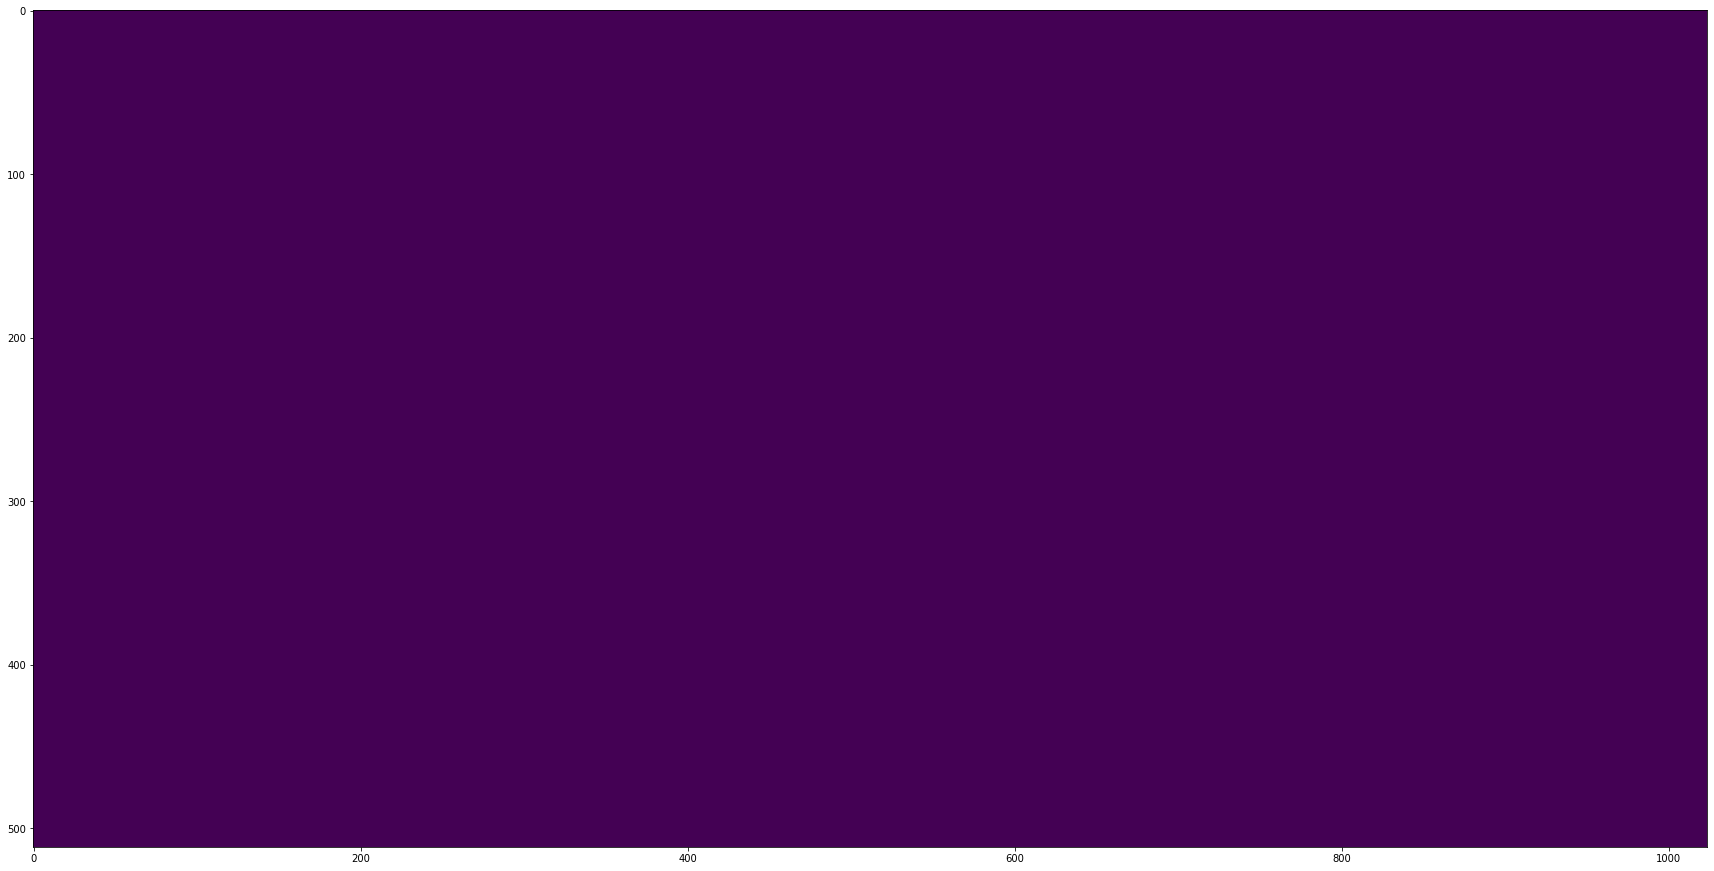

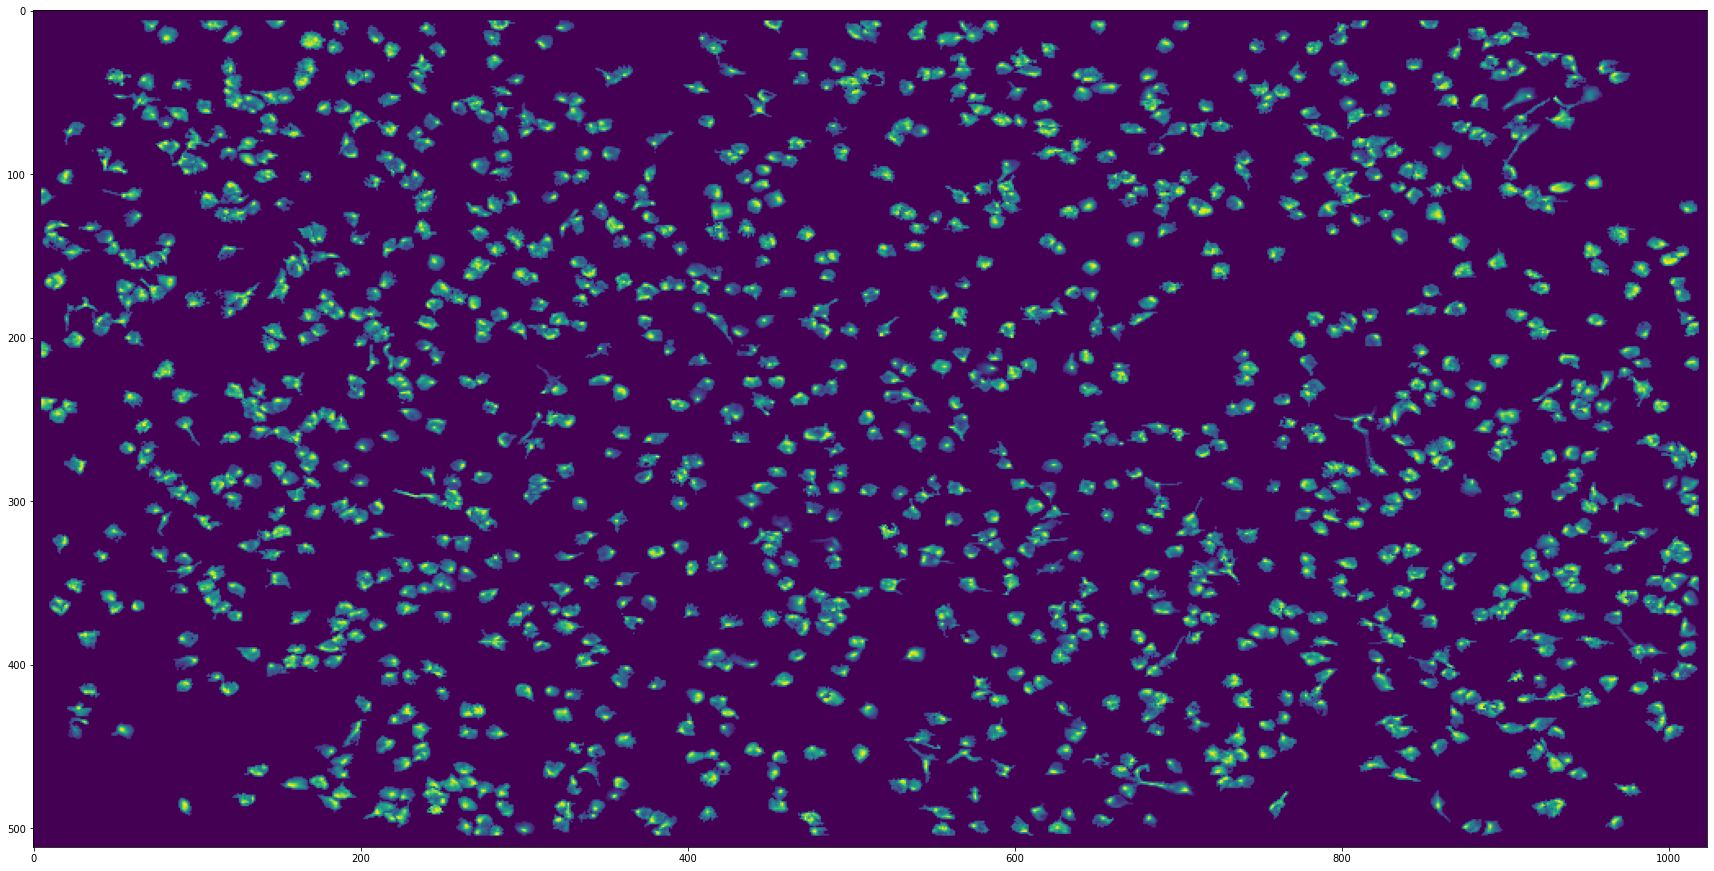

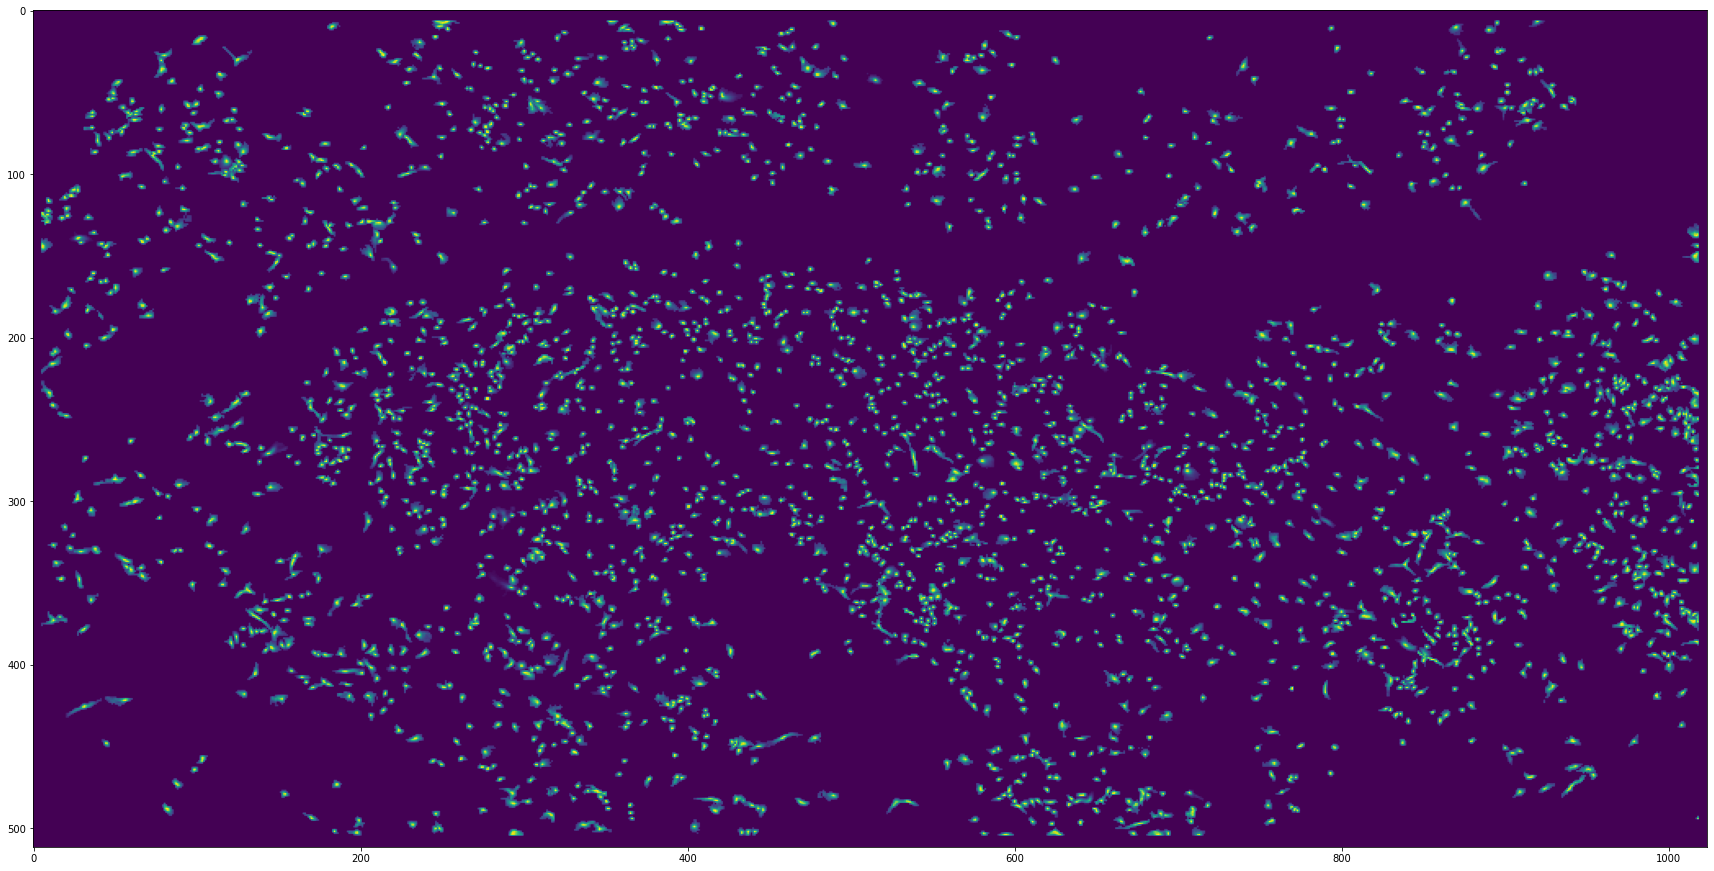

In [16]:
## Look at all the cells at once
%matplotlib inline

masks_all_classified = np.zeros((meanImg.shape[0] , meanImg.shape[1] , 6))
for jj in range(6):
    for ii in np.where(predictions==jj)[0]:
        masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam'] / (np.max(stat[()][ii]['lam'])**2)
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam']
    plt.figure(figsize=(30,20))
    plt.imshow(masks_all_classified[:,:,jj])
    
print(f'Number of Class 1 ROIs: {sum(predictions==0)}')
print(f'Number of Class 2 ROIs: {sum(predictions==1)}')
print(f'Number of Class 5 ROIs: {sum(predictions==4)}')
print(f'Number of Class 6 ROIs: {sum(predictions==5)}')

In [18]:
groups_to_include = [0,1,4]


In [23]:
toChange_list = list(np.zeros(predictions.shape[0])*np.nan)

In [27]:
## UNCOMMENT to Look at individual cells

## Press ENTER to advance. Press ESC to exit
## Press 1 to include or 0 to exclude or ENTER to leave as is

class_to_test = 4

def onKeyPress(event):
#     print('press', event.key)
    sys.stdout.flush()
    global cell_checked
    global exit_pref
    global toChange_list
    global ROI_iter
    if event.key == 'enter':
        cell_checked = 1
    elif event.key == 'escape':
        cell_checked = 1
        exit_pref = 1
    elif event.key.isnumeric():
        toChange_list[ROI_idx_totest[ROI_iter]] = event.key
        cell_checked = 1
    elif event.key == '-':
        ROI_iter-=2
        cell_checked = 1
    return

%matplotlib qt
# plt.figure()
# plt.pause(0.5) 
iter_start = 0
fig, (ax1, ax2) = plt.subplots(2, 1)
exit_pref = 0

# for ROI_iter in np.where(predictions ==class_to_test)[0]:
ROI_idx_totest = np.where(predictions ==class_to_test)[0]
ROI_iter = 0
while exit_pref==0 and ROI_iter<len(ROI_idx_totest):
    if ROI_idx_totest[ROI_iter] >= iter_start:
#             plt.subplot(2,1,1)
#             plt.imshow(images[ii, : , :])
#             plt.title(ii)
#             plt.subplot(2,1,2)
# #             plt.hold = False
#             plt.cla()
#             plt.plot(dFoF.T[:,ii])
        cell_checked = 0
        cid = fig.canvas.mpl_connect('key_press_event', onKeyPress)

        ax1.cla()
        ax1.imshow(images[ROI_idx_totest[ROI_iter], : , :])
        ax1.set_title(f'ROI#: {ROI_idx_totest[ROI_iter]}   ;   toChange={toChange_list[ROI_idx_totest[ROI_iter]]}')

        ax2.cla()
        ax2.plot(dFoF.T[:,ROI_iter])

        plt.show(block=False)
        while cell_checked==0:
            plt.pause(0.01) 
#         ROI_iter+=1
    ROI_iter+=1

#     if exit_pref==1:
#         break

#                 input_val = input()
#                 if not input_val:
#                     continue
#                 if np.int8(input_val) >=7:
#                     break
#                 plt.pause(0.05) 
plt.close()

In [28]:
fig.canvas.mpl_disconnect(cid)


In [45]:
%matplotlib qt
plt.figure()
plt.plot(toChange[~np.isnan(toChange)] < 5)

In [29]:
# find idx of ROIs to change
idx_toChange = np.array(toChange_list)
idx_toChange = idx_toChange!='nan' 

toChange = np.zeros(predictions.shape[0])*np.nan
toChange[idx_toChange]=np.array(toChange_list)[idx_toChange]
# plt.figure()
# plt.plot(toChange ,'.')

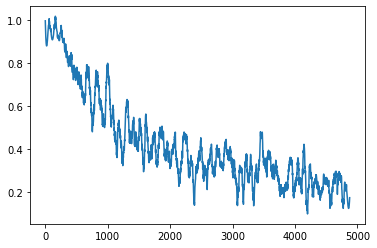

In [19]:
%matplotlib inline
toInclude = np.array([predictions[ii] in groups_to_include for ii in range(len(predictions))] , dtype=bool)
plt.figure()
plt.plot(scipy.signal.savgol_filter(toInclude,101,3))

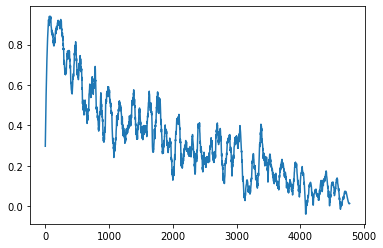

In [48]:
toInclude[~np.isnan(toChange)] = toChange[~np.isnan(toChange)] < 5
plt.figure()
plt.plot(scipy.signal.savgol_filter(toInclude,101,3))

In [35]:
## USE iscell (OPTIONAL)

dir_S2p_load = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/suite2p/plane0'
fileName_iscell_load = 'iscell.npy'
path_load = f'{dir_S2p_load}{slash_type}{fileName_iscell_load}'
iscell = np.load(path_load, allow_pickle=True)
print(f'iscell file loaded from: {path_load}')

toInclude = iscell[:,0]
toExclude = toInclude==0

iscell file loaded from: /media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/suite2p/plane0/iscell.npy


In [36]:
toExclude_manuallyClicked = np.zeros_like(toInclude)
toInclude_manuallyClicked = np.zeros_like(toInclude)

In [37]:
np.sum(toInclude) - np.sum(- toExclude_manuallyClicked)

1726.0

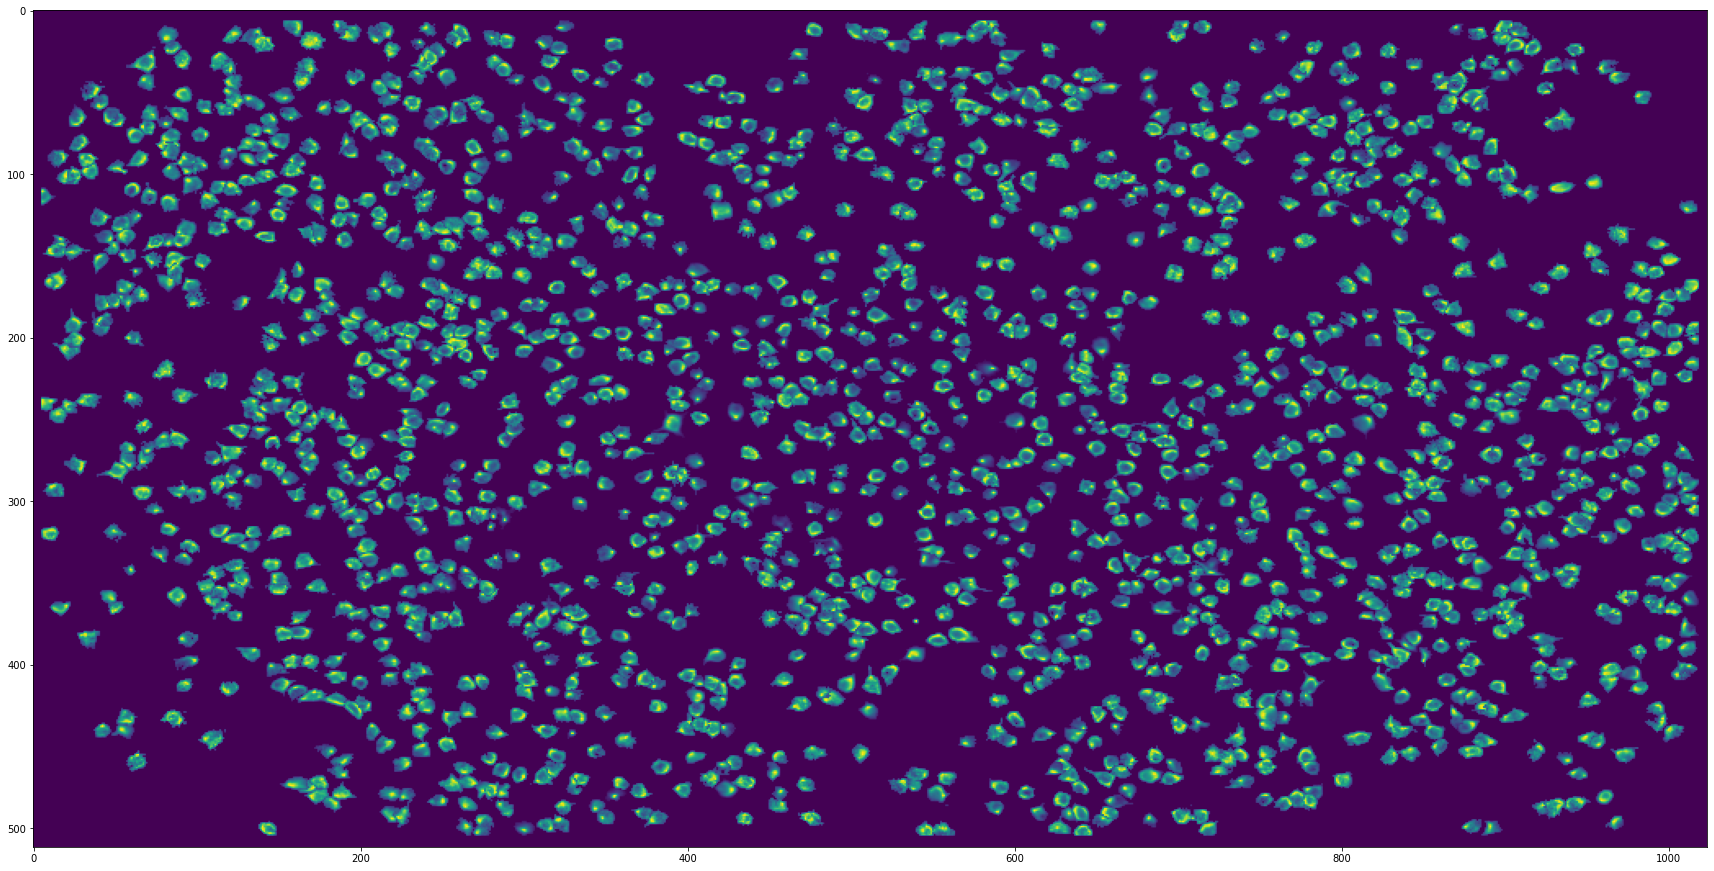

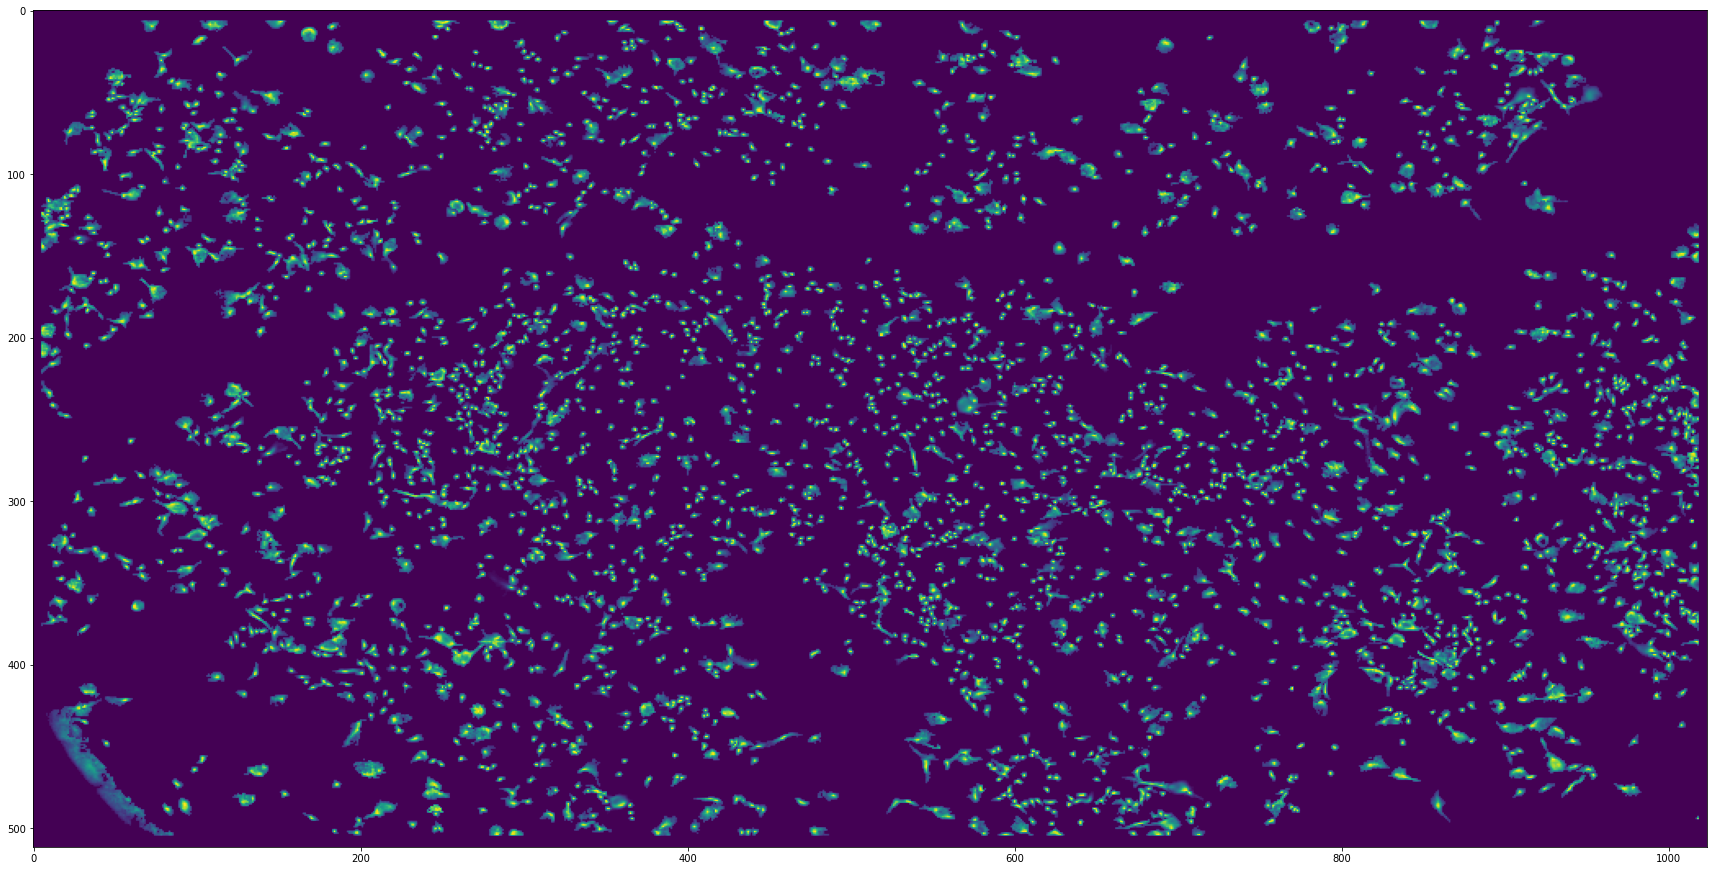

In [40]:
## Look at all the cells at once
%matplotlib inline

masks_toInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
masks_toExclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
for ii in np.where(np.uint8(toInclude) - toExclude_manuallyClicked)[0]:
    masks_toInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
for ii in np.where(np.uint8(toExclude) - toInclude_manuallyClicked)[0]:
    masks_toExclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam'] / (np.max(stat[()][ii]['lam'])**2)
#         masks_all_classified[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] , jj] = stat[()][ii]['lam']
plt.figure(figsize=(30,20))
plt.imshow(masks_toInclude)
plt.figure(figsize=(30,20))
plt.imshow(masks_toExclude)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
from scipy.integrate import trapz
from matplotlib import animation
%matplotlib qt
%matplotlib qt

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def append_ROI_toExclude(coords):
    global toExclude_manuallyClicked
    global footprints_tall
    pixel_match_bool = (footprints_tall[:,1] == np.round(coords[-1][1])) * (footprints_tall[:,2] == np.round(coords[-1][0]))
    check_found_single_ROI = sum(pixel_match_bool)
    if check_found_single_ROI:
        ROI_toExclude = int(footprints_tall[np.where(pixel_match_bool)[0][0] , 0])
        print(f'Excluding ROI#: {ROI_toExclude}')
        if ROI_toExclude in np.where(toInclude)[0]:
            toExclude_manuallyClicked[ROI_toExclude] = 1
    
# Simple mouse click function to store coordinates
def onclick(event):
    if event.button is MouseButton.LEFT:

        global ix, iy
        ix, iy = event.xdata, event.ydata
#         print(event)

        # print 'x = %d, y = %d'%(
        #     ix, iy)

        # assign global variable to access outside of function
        global coords
        coords.append((ix, iy))
        
        append_ROI_toExclude(coords)
        update_image()
        return

def update_image():
    masks_toInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
    for ii in np.where(np.uint8(toInclude) - toExclude_manuallyClicked)[0]:
        masks_toInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
    ax1.clear()
    im = ax1.imshow(masks_toInclude)
    plt.draw()
    

fig, (ax1) = plt.subplots(1, 1, figsize=(30,20))
im = ax1.imshow(masks_toInclude)
plt.show(block=False)
# ani = animation.FuncAnimation(fig, update_image, interval=0)

plt.pause(2) 
            
coords = []

# Call click func
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# plt.show(1)

Excluding ROI#: 4769
Excluding ROI#: 286
Excluding ROI#: 662
Excluding ROI#: 4020
Excluding ROI#: 452
Excluding ROI#: 2047
Excluding ROI#: 176
Excluding ROI#: 4851
Excluding ROI#: 1254
Excluding ROI#: 3992
Excluding ROI#: 1094
Excluding ROI#: 259
Excluding ROI#: 619
Excluding ROI#: 2120
Excluding ROI#: 213
Excluding ROI#: 3283
Excluding ROI#: 1546
Excluding ROI#: 2929
Excluding ROI#: 930
Excluding ROI#: 3292
Excluding ROI#: 4160
Excluding ROI#: 438
Excluding ROI#: 3207
Excluding ROI#: 3026
Excluding ROI#: 390
Excluding ROI#: 2896
Excluding ROI#: 3771
Excluding ROI#: 838
Excluding ROI#: 479
Excluding ROI#: 2868
Excluding ROI#: 2885
Excluding ROI#: 189
Excluding ROI#: 2126
Excluding ROI#: 1876
Excluding ROI#: 4739
Excluding ROI#: 2979
Excluding ROI#: 1999
Excluding ROI#: 797
Excluding ROI#: 735
Excluding ROI#: 2106
Excluding ROI#: 1257
Excluding ROI#: 211
Excluding ROI#: 2389
Excluding ROI#: 4404
Excluding ROI#: 756
Excluding ROI#: 522
Excluding ROI#: 2448
Excluding ROI#: 491
Excluding R

Excluding ROI#: 2260
Excluding ROI#: 3369
Excluding ROI#: 1884
Excluding ROI#: 3444
Excluding ROI#: 3783
Excluding ROI#: 2953
Excluding ROI#: 12
Excluding ROI#: 2256
Excluding ROI#: 4441
Excluding ROI#: 2921
Excluding ROI#: 860
Excluding ROI#: 1527
Excluding ROI#: 2247
Excluding ROI#: 1771
Excluding ROI#: 769
Excluding ROI#: 474
Excluding ROI#: 3307
Excluding ROI#: 3128
Excluding ROI#: 818
Excluding ROI#: 4631
Excluding ROI#: 539
Excluding ROI#: 3001
Excluding ROI#: 3710
Excluding ROI#: 810
Excluding ROI#: 3117
Excluding ROI#: 2545
Excluding ROI#: 2977
Excluding ROI#: 3719
Excluding ROI#: 931
Excluding ROI#: 3605
Excluding ROI#: 381
Excluding ROI#: 1733
Excluding ROI#: 1588
Excluding ROI#: 1814
Excluding ROI#: 4637
Excluding ROI#: 982
Excluding ROI#: 3834
Excluding ROI#: 1795
Excluding ROI#: 993
Excluding ROI#: 3801
Excluding ROI#: 2434
Excluding ROI#: 64
Excluding ROI#: 1639
Excluding ROI#: 3845
Excluding ROI#: 2095
Excluding ROI#: 2998
Excluding ROI#: 4687
Excluding ROI#: 2221
Exclud

In [47]:
fig.canvas.mpl_disconnect(cid)

Final number of included ROIs:  1286.0
Final number of NOT included ROIs:  3592.0


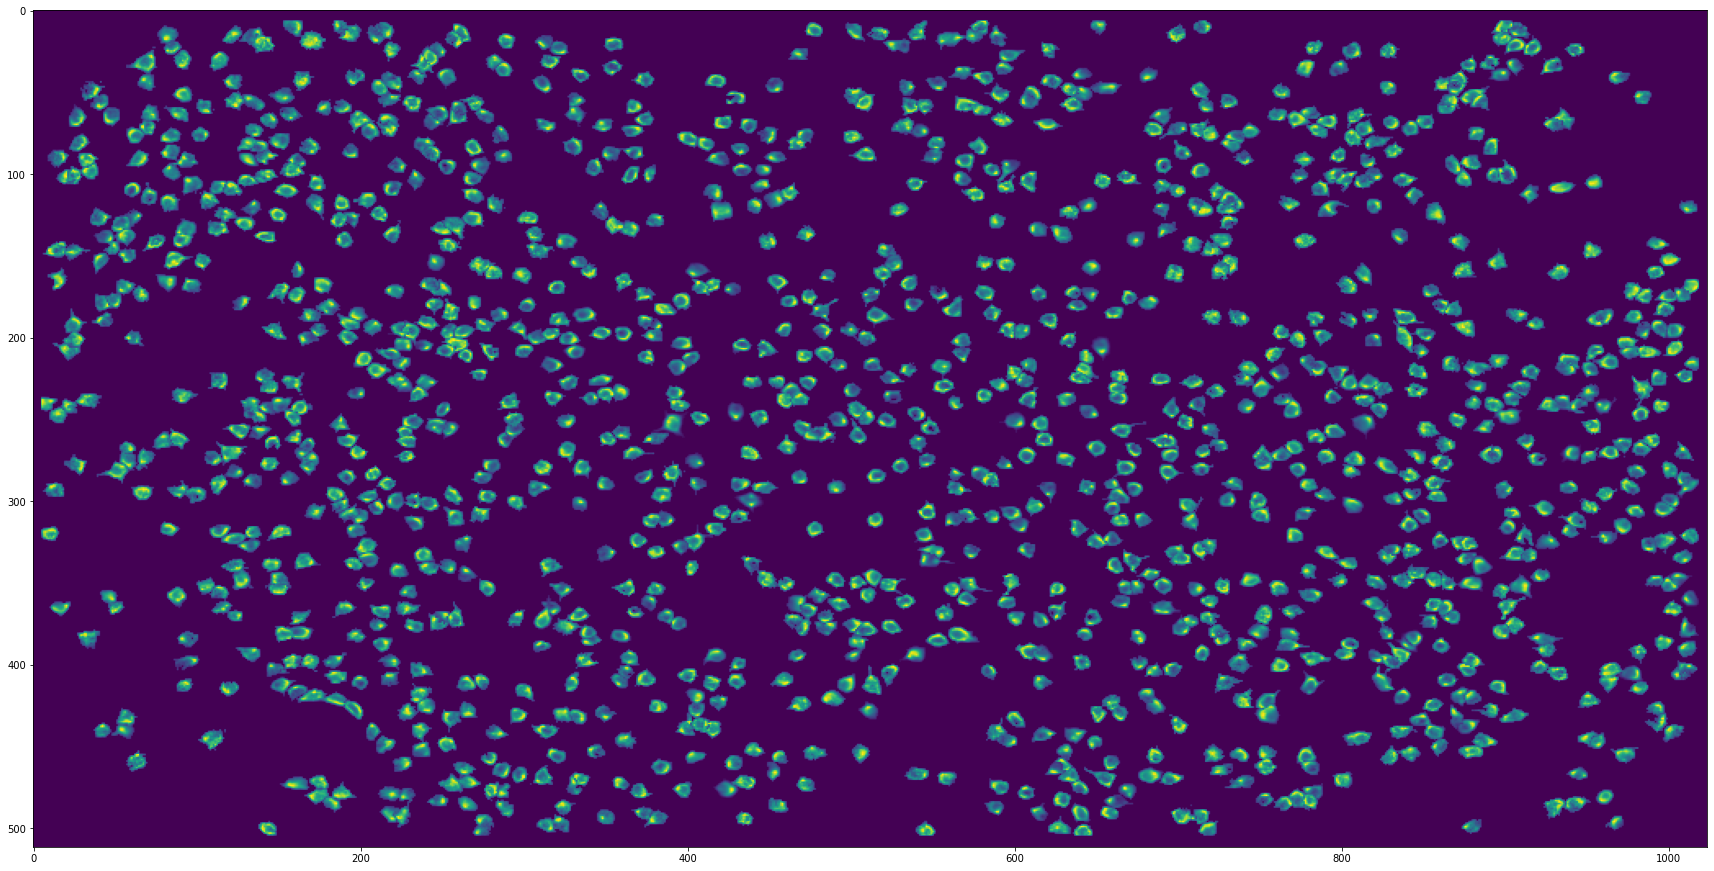

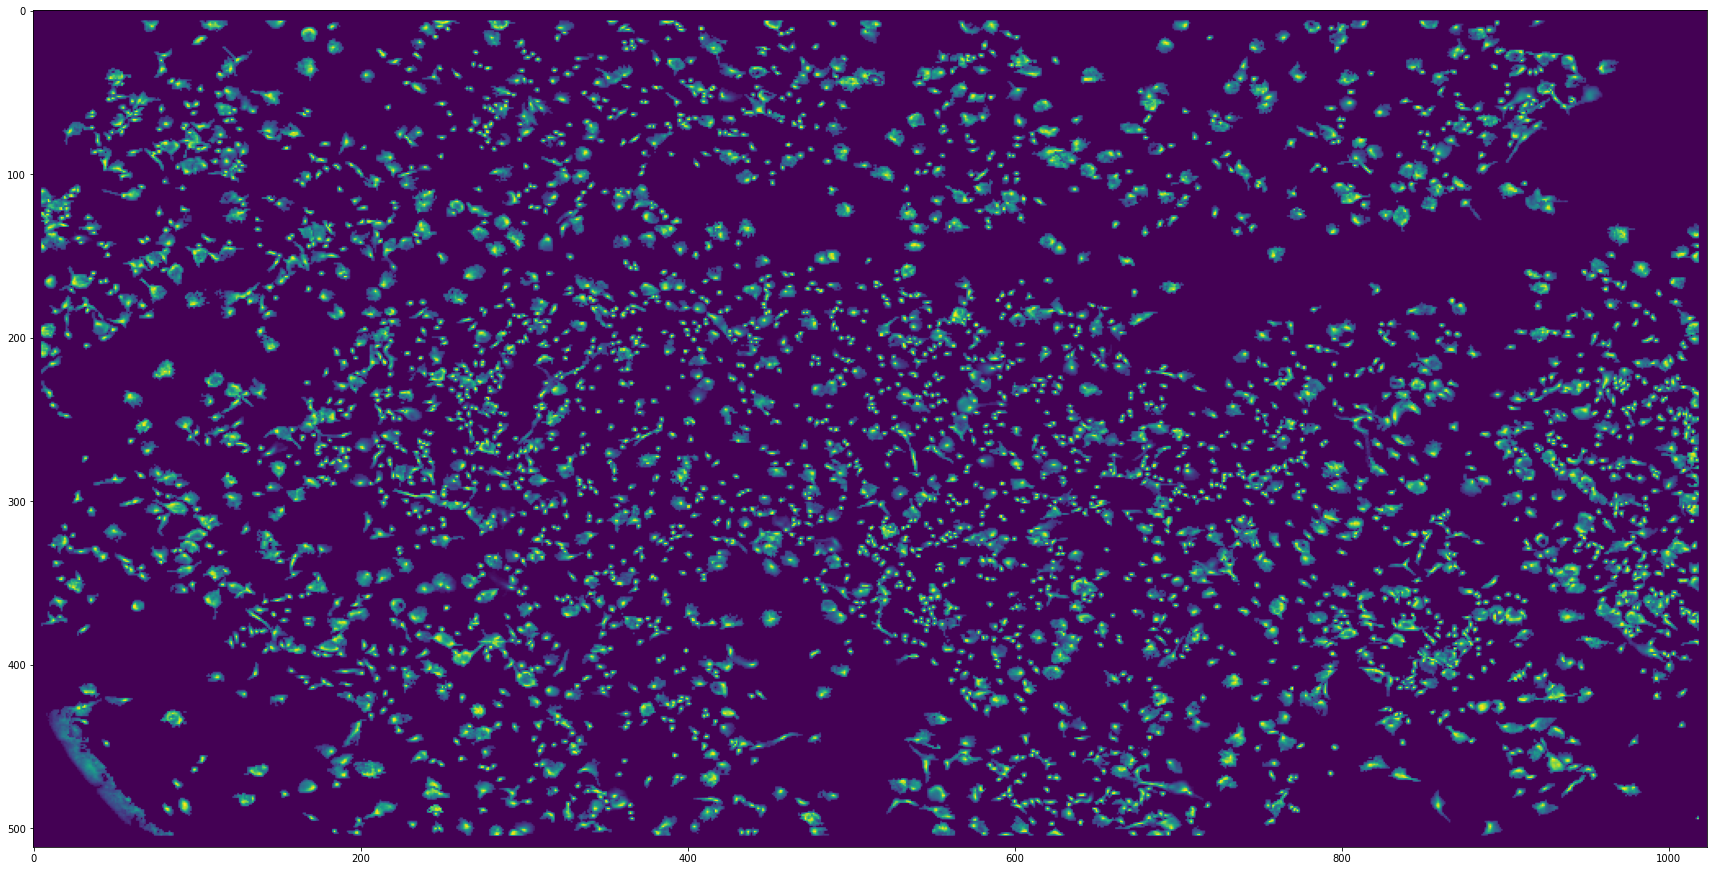

In [48]:
toInclude_final = np.uint8(toInclude) - toExclude_manuallyClicked
print(f'Final number of included ROIs:  {np.sum(toInclude_final)}')
print(f'Final number of NOT included ROIs:  {np.sum(1-toInclude_final)}')

## Look at all the cells at once
%matplotlib inline

masks_toInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
masks_notToInclude = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
for ii in np.where(toInclude_final)[0]:
    masks_toInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
for ii in np.where(1-toInclude_final)[0]:
    masks_notToInclude[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])

plt.figure(figsize=(30,20))
plt.imshow(masks_toInclude)
plt.figure(figsize=(30,20))
plt.imshow(masks_notToInclude)

In [49]:
# manual curation variables:
manual_selection_vars = dict([
    ('toInclude_preExclusion', toInclude), 
    ('toExclude_manuallyClicked', toExclude_manuallyClicked), 
    ('predictions', predictions),
    ('output_activations', output),
    ('prob', prob),
    ('toInclude_final', toInclude_final)
    ])

In [50]:
save_dir = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112'

save_name = f'IsCell_ROIClassifier'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , toInclude_final)

save_name = f'manual_selection_vars'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , manual_selection_vars)

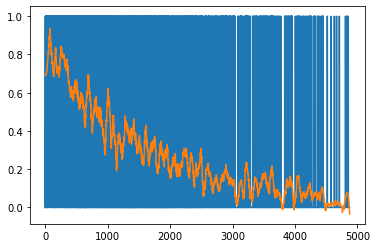

In [51]:
plt.figure()
plt.plot(toInclude_final)
plt.plot(scipy.signal.savgol_filter(toInclude_final,101,3))